# ニューラルネットスクラッチ

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from pyprind import ProgBar
%matplotlib inline

Using TensorFlow backend.


- 実装の流れ
  - シグモイド関数の定義
  - ソフトマックス関数の定義
  - クロスエントロピー関数の定義
  - フィードフォワードの定義
  - バックプロパゲーションの定義
  - クラス化

## シグモイド関数の定義

In [2]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

## ソフトマックス関数の定義

In [3]:
def softmax(x):
    return np.exp(w_in_3)/np.sum(np.exp(w_in_3), axis=1)[:,np.newaxis]

- オーバーフロー対策をする

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

## クロスエントロピーの定義

In [5]:
def cross_entropy(y_pred, y_true) :
    delta = 1e-7
    return -np.sum(y_true*np.log(y_pred+delta))

## 簡単なサンプルで実験していく

In [6]:
X = np.array([[1,2,3],
             [4,5,6]])
y = np.array([1,2])

In [7]:
batch_size = 2 # バッチサイズ
n_features = 3 # 特徴量の数
n_nodes1 = 5 # 1層目のノード数
n_nodes2 = 4 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

- 1層目

In [8]:
# 重みとバイアスの初期化
W_1 = np.random.randn(n_features,n_nodes1)
b_1 = np.random.randn(n_nodes1)

In [9]:
# 内積
w_in_i = np.dot(X, W_1)
w_in_i

array([[-2.36544693,  2.0156434 ,  3.3702538 ,  1.85901987, -2.17231613],
       [-3.70351887,  2.06696805, 11.50276637,  4.93268709, -3.53497575]])

In [10]:
# 内積+バイアス
w_in_1 = np.dot(X, W_1) + b_1
w_in_1

array([[-3.85647087,  3.97401814,  3.26496391,  0.7537935 , -3.41076277],
       [-5.1945428 ,  4.02534279, 11.39747648,  3.82746072, -4.77342239]])

In [11]:
# シグモイド関数に噛ませる。
out_1=sigmoid(w_in_1)
out_1

array([[0.02070473, 0.98154909, 0.96320711, 0.68000472, 0.03196079],
       [0.00551615, 0.98245599, 0.99998878, 0.9786988 , 0.00838058]])

- 2層目

In [12]:
# 重みの初期化(1層目のノード数、２層目のノード数)
W_2 = np.random.randn(n_nodes1, n_nodes2)

In [13]:
W_2

array([[-0.12469756,  2.01193993, -0.88906133, -1.37797294],
       [-1.07943265,  0.53607271,  3.01768317,  1.64079522],
       [-1.41359714,  0.34281434,  0.5469319 ,  0.25059101],
       [ 0.69661312,  1.38007656, -0.53875753, -0.28582336],
       [-0.21421562, -0.5511236 , -1.41319095, -0.89971673]])

In [14]:
# バイアスの初期化(2層目のノード数)
b_2 = np.random.randn(n_nodes2)

# 内積計算
w_in_2 = np.dot(out_1, W_2) + b_2
w_in_2

array([[0.17058415, 1.37427885, 2.27482287, 2.14591552],
       [0.33263021, 1.7820321 , 2.1835799 , 2.11339193]])

In [15]:
# 活性化関数
# out_2=sigmoid(w_in_2) #tanhへ切り替え可能
out_2=np.tanh(w_in_2)
out_2

array([[0.16894858, 0.87966368, 0.97907925, 0.97300952],
       [0.32088215, 0.94491329, 0.97494345, 0.97122161]])

- ３層目

In [16]:
# 重みの初期化(2層目のノード数, 出力の数)
W_3 = np.random.randn(n_nodes2, n_output)
W_3

array([[ 0.28100519, -0.98995388, -1.97864999,  0.83202602,  1.85531293,
         2.10350603,  0.30726983,  0.86213519,  2.59091617,  0.08012837],
       [-2.58909306, -1.38591752,  0.57840016,  0.80324877, -1.34874297,
         0.21532454, -1.49999161, -0.19732019, -1.29045851, -0.16544126],
       [ 0.05446355, -0.88284559,  1.81386994, -1.25932405,  0.65376538,
         0.97428779, -1.22362923,  0.85821524,  0.91773689, -1.59063555],
       [ 0.16364425, -0.55088103,  0.64063385,  2.06787794, -0.75992366,
         0.19385227, -1.77397831,  0.94645227, -0.61502489, -0.38165502]])

In [17]:
# バイアスの初期化(出力の数)
b_3 = np.empty(n_output)

# 内積計算
w_in_3 = np.dot(out_2, W_3) + b_3
w_in_3

array([[-1.99679943, -1.80523181,  3.53697987,  2.30624997, -0.94035176,
         1.69283875, -3.20924713,  2.73323769,  0.581373  , -2.05232675],
       [-2.12356045, -2.0414334 ,  3.26544969,  2.48658545, -0.74781757,
         2.02210572, -3.25220399,  2.84610832,  0.88812226, -2.04368661]])

In [18]:
# ソフトマックス関数
softmax(w_in_3)

array([[0.00200057, 0.00242298, 0.50634167, 0.14789192, 0.00575391,
        0.08008356, 0.00059511, 0.22666417, 0.0263536 , 0.00189251],
       [0.00180376, 0.00195816, 0.39500017, 0.18127622, 0.00713933,
        0.11392521, 0.00058347, 0.2597046 , 0.03665533, 0.00195375]])

- フィードフォワードをまとめる

フォワード    
```python
batch_size = 2 # バッチサイズ
n_features = 3 # 特徴量の数
n_nodes1 = 3 # 1層目のノード数
n_nodes2 = 4 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
# 初期化（1層目）
w_1 = np.empty((n_features,n_nodes1))
b_1 = np.empty(n_nodes1)
w_in_1 = np.dot(X, w_1) + b_1

# シグモイド関数に噛ませる。
out_1=sigmoid(w_in_1)
out_1

# ２層目
w_2 = np.random.randn(n_nodes1, n_nodes2)
b_2 = np.random.randn(n_nodes2)
w_in_2 = np.dot(out_1, w_2) + b_2
out_2=sigmoid(w_in_2)

# ３層目
w_3 = np.random.randn(n_nodes2, n_output)
b_3 = np.random.randn(n_output)
w_in_3 = np.dot(out_2, w_3) + b_3
y_pred = softmax(w_in_3)
```

## バックプロバゲーション

In [19]:
# 予測値(サンプルデータ)
y_pred

NameError: name 'y_pred' is not defined

In [ ]:
# 実測値（サンプルデータ）
y = np.array([[1,0,0,0,0,0,0,0,0,0],
             [0,0,1,0,0,0,0,0,0,0]])

In [ ]:
# 誤差
y_hat = y_pred-y
y_hat

In [ ]:
# バッチの平均をとる
np.average(y_hat, axis=0)

In [20]:
# 内積でサンプルが織り込まれているので、あとで割る。
lr = 0.01
lr*np.dot(w_in_2.T, y_hat)/batch_size

NameError: name 'y_hat' is not defined

In [21]:
lr = 0.01
# 3層目
y_hat = y_pred - y
b_3 = b_3 + lr * np.average(y - y_hat, axis=0)
back_z2 = np.dot(y_hat, w_3.T)
w_3 = w_3 + lr * np.dot(w_in_2.T, y_hat)/batch_size

# 2層目
back_a2 = back_z2 * (1-np.power(np.tanh(w_in_2),2))
b_2 = b_2 + lr * np.average(back_a2, axis=0)
back_z1 = np.dot(back_a2, w_2.T)
w_2 = w_2 + lr * np.dot(w_in_1.T, back_a2)/batch_size


# 1層目
back_a1 = back_z1 * (1-np.power(np.tanh(w_in_1),2))
b_1 = b_1 + lr * np.average(back_a1, axis=0)
w_1 = w_1 + lr * np.dot(X.T, back_a1)/batch_size


NameError: name 'y_pred' is not defined

## フォワードプロパゲーションとバックプロパゲーション

[まとめたコード]
```python
batch_size = 10 # バッチサイズ
n_features = 3 # 特徴量の数
n_nodes1 = 3 # 1層目のノード数
n_nodes2 = 4 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

# フォワードプロパゲーション
# 初期化（1層目）
w_1 = np.empty((n_features,n_nodes1))
b_1 = np.empty(n_nodes1)
w_in_1 = np.dot(X, w_1) + b_1

# シグモイド関数に噛ませる。
out_1=sigmoid(w_in_1)
out_1

# ２層目
w_2 = np.empty((n_nodes1, n_nodes2))
b_2 = np.empty(n_nodes2)
w_in_2 = np.dot(out_1, w_2) + b_2
out_2=sigmoid(w_in_2)

# ３層目
w_3 = np.empty((n_nodes2, n_output))
b_3 = np.empty(n_output)
w_in_3 = np.dot(out_2, w_3) + b_3
y_pred = softmax(w_in_3)

# バックプロパゲーション

# 3層目
y_hat = y_pred - y
b_3 = b_3 + lr * np.average(b_3 - y_hat, axis=0)
back_z2 = np.dot(y_hat, w_3.T)
w_3 = w_3 + lr * np.dot(w_in_2.T, y_hat)/batch_size

# 2層目
back_a2 = back_z2 * (1-np.power(np.tanh(w_in_2), 2))
b_2 = b_2 + lr * np.average(back_a2, axis=0)
back_z1 = np.dot(back_a2, w_2.T)
w_2 = w_2 + lr * np.dot(w_in_1.T, back_a2)/batch_size


# 1層目
back_a1 = back_z1 * (1-np.power(np.tanh(w_in_1), 2))
b_1 = b_1 + lr * np.average(back_a1, axis=0)
w_1 = w_1 + lr * np.dot(X.T, back_a1)/batch_size
```

# バッチ学習させてみる

In [22]:
X = np.array([[1,2,3],
             [4,5,6]])
# 実測値（サンプルデータ）
y = np.array([[1,0,0,0,0,0,0,0,0,0],
             [0,0,1,0,0,0,0,0,0,0]])

batch_size = 2 # バッチサイズ
n_features = 3 # 特徴量の数
n_nodes1 = 4 # 1層目のノード数
n_nodes2 = 2 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
sigma = 0.1 # ガウス分布の標準偏差
lr = 0.01

w_1 = sigma * np.random.randn(n_features,n_nodes1)
b_1 = sigma * np.random.randn(n_nodes1)
w_2 = sigma * np.random.randn(n_nodes1, n_nodes2)
b_2 = sigma * np.random.randn(n_nodes2)
w_3 = sigma * np.random.randn(n_nodes2, n_output)
b_3 = np.empty(n_output)
for _ in range(2):

    # フォワードプロパゲーション
    # 初期化（1層目）
    # w_1 = np.empty((n_features,n_nodes1))
    # b_1 = np.empty(n_nodes1)
    w_in_1 = np.dot(X, w_1) + b_1

    # シグモイド関数に噛ませる。
    out_1=np.tanh(w_in_1)

    # ２層目
    # w_2 = np.empty((n_nodes1, n_nodes2))
    # b_2 = np.empty(n_nodes2)
    w_in_2 = np.dot(out_1, w_2) + b_2
    out_2=np.tanh(w_in_2)

    # ３層目
    # w_3 = np.empty((n_nodes2, n_output))
    # b_3 = np.empty(n_output)
    w_in_3 = np.dot(out_2, w_3) + b_3
    y_pred = softmax(w_in_3)

    # バックプロパゲーション

    # 3層目
    y_hat = y_pred - y
    b_3 = b_3 - lr * np.average(y_hat, axis=0)
    back_z2 = np.dot(y_hat, w_3.T)
    w_3 = w_3 - lr * np.dot(out_2.T, y_hat)/batch_size

    # 2層目
    back_a2 = back_z2 * (1-np.power(np.tanh(w_in_2), 2))
    b_2 = b_2 - lr * np.average(back_a2, axis=0)
    back_z1 = np.dot(back_a2, w_2.T)
    w_2 = w_2 - lr * np.dot(out_1.T, back_a2)/batch_size


    # 1層目
    back_a1 = back_z1 * (1-np.power(np.tanh(w_in_1), 2))
    b_1 = b_1 - lr * np.average(back_a1, axis=0)
    w_1 = w_1 - lr * np.dot(X.T, back_a1)/batch_size
    
    print('w_1: {}'.format(out_2))

w_1: [[-0.04500806 -0.04851256]
 [-0.10503797 -0.0568944 ]]
w_1: [[-0.04535317 -0.0473531 ]
 [-0.10520767 -0.05469955]]


In [23]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [24]:
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

## 平滑化

In [25]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

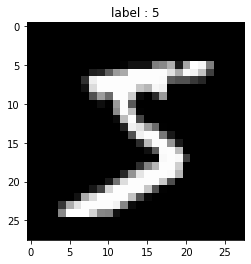

In [26]:
# はじめの数字を表示させる
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
# print(image) # 値を確認

## データの読み込み&前処理

In [27]:
# mnistの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# floatに変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

# 正規化
X_train /= 255
X_test /= 255

In [28]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


- ミニバッチを取得する関数

In [30]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

- 活性化関数をハイパボリックタンジェントのみバージョン

In [40]:
# 以下をニューラルネットワークのクラス内で呼び出す

get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=10)

print(len(get_mini_batch)) # 4800
batch_size = 10 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
epochs = 10


sigma = 0.01 # ガウス分布の標準偏差
# それぞれの重み、バイアスの初期値
w_1 = sigma * np.random.randn(n_features,n_nodes1)
b_1 = sigma * np.random.randn(n_nodes1)
w_2 = sigma * np.random.randn(n_nodes1, n_nodes2)
b_2 = sigma * np.random.randn(n_nodes2)
w_3 = sigma * np.random.randn(n_nodes2, n_output)
b_3 = sigma * np.random.randn(n_output)
lr = 0.01

ave_loss_list = np.empty(epochs)

for epoch in range(epochs):
    print('epoch: {}'.format(epoch+1))
    loss_list = np.empty(5)
    for mini_X_train, mini_y_train in get_mini_batch:
        
        # フォワードプロパゲーション
        # 初期化（1層目）
        # w_1 = np.empty((n_features,n_nodes1))
        # b_1 = np.empty(n_nodes1)
        w_in_1 = np.dot(mini_X_train, w_1) + b_1

        # シグモイド関数に噛ませる。
        out_1 = np.tanh(w_in_1)

        # ２層目
        # w_2 = np.empty((n_nodes1, n_nodes2))
        # b_2 = np.empty(n_nodes2)
        w_in_2 = np.dot(out_1, w_2) + b_2
        out_2 = np.tanh(w_in_2)

        # ３層目
        # w_3 = np.empty((n_nodes2, n_output))
        # b_3 = np.empty(n_output)
        w_in_3 = np.dot(out_2, w_3) + b_3
        y_pred = softmax(w_in_3)

        # バックプロパゲーション

        # 3層目
        y_hat = y_pred - mini_y_train
        b_3 -= lr * np.mean(y_hat, axis=0)
        back_z2 = np.dot(y_hat, w_3.T)
        w_3 -= lr * np.dot(out_2.T, y_hat)/batch_size

        # 2層目
        back_a2 = back_z2 * (1-np.power(np.tanh(w_in_2), 2))
        b_2 -= lr * np.mean(back_a2, axis=0)
        back_z1 = np.dot(back_a2, w_2.T)
        w_2 -= lr * np.dot(out_1.T, back_a2)/batch_size


        # 1層目
        back_a1 = back_z1 * (1-np.power(np.tanh(w_in_1), 2))
        b_1 -= lr * np.mean(back_a1, axis=0)
        w_1 -= lr * np.dot(mini_X_train.T, back_a1)/batch_size
    ave_loss_list[epoch]=cross_entropy(y_pred, mini_y_train)

4800
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10


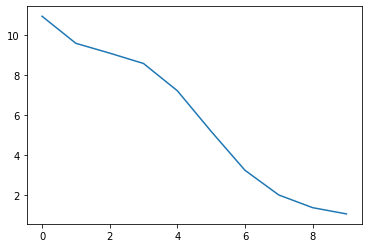

In [41]:
plt.plot(ave_loss_list);

In [42]:
mini_y_train[0:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [43]:
y_pred[0:5]

array([[1.32784073e-05, 5.95520409e-07, 3.14345292e-04, 2.67439404e-03,
        1.42093405e-06, 5.79641998e-06, 5.56633329e-11, 9.96734007e-01,
        3.34191115e-05, 2.22743235e-04],
       [5.25613185e-06, 4.93695592e-05, 2.80010731e-07, 2.49890601e-05,
        5.21369854e-02, 1.83426783e-05, 1.36534936e-06, 1.88340301e-02,
        2.38027490e-03, 9.26549107e-01],
       [1.14351903e-06, 2.73976867e-02, 7.31570587e-03, 7.72189110e-01,
        7.70244503e-04, 1.62030782e-01, 3.57418020e-03, 4.44834452e-04,
        2.62662680e-02, 1.00448785e-05],
       [1.44625846e-06, 8.10718113e-05, 6.62876524e-04, 4.88003974e-04,
        4.84749241e-05, 2.66806153e-04, 1.75922247e-06, 1.93483560e-05,
        9.97837748e-01, 5.92464806e-04],
       [2.67657497e-06, 1.73123564e-05, 2.07490165e-05, 5.66542695e-01,
        4.76440292e-06, 4.32855258e-01, 3.41456498e-07, 4.05919826e-06,
        4.66159828e-04, 8.59841807e-05]])

In [59]:
np.argmax(y_pred[0:5],axis=1)

array([5, 2, 2, 6, 1, 4, 7, 9, 0, 9])

In [67]:
np.argmax(mini_y_train[0:5], axis=1)

array([5, 2, 2, 6, 1])

- シグモイドのみバージョン

学習率をうまく設定しないと局所最適解に落ち込む

In [68]:
# 以下をニューラルネットワークのクラス内で呼び出す

get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=10)

batch_size = 10 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）


sigma = 0.01 # ガウス分布の標準偏差
# それぞれの重み、バイアスの初期値
w_1 = sigma * np.random.randn(n_features,n_nodes1)
b_1 = sigma * np.random.randn(n_nodes1)
w_2 = sigma * np.random.randn(n_nodes1, n_nodes2)
b_2 = sigma * np.random.randn(n_nodes2)
w_3 = sigma * np.random.randn(n_nodes2, n_output)
b_3 = sigma * np.random.randn(n_output)
lr = 0.1

loss_list = []

for epoch in range(2):
    print('epoch: {}'.format(epoch+1))
    for mini_X_train, mini_y_train in get_mini_batch:
        
        # フォワードプロパゲーション
        # 初期化（1層目）
        # w_1 = np.empty((n_features,n_nodes1))
        # b_1 = np.empty(n_nodes1)
        w_in_1 = np.dot(mini_X_train, w_1) + b_1

        # シグモイド関数に噛ませる。
        out_1 = sigmoid(w_in_1)  #(10,400)
        

        # ２層目
        w_in_2 = np.dot(out_1, w_2) + b_2 #(10,400),(400,200)=(10,200)
        out_2 = sigmoid(w_in_2) 

        # ３層目
        w_in_3 = np.dot(out_2, w_3) + b_3
        y_pred = softmax(w_in_3)

        # バックプロパゲーション
        # 3層目
        y_hat = y_pred - mini_y_train #(10,)
        b_3 -= lr * np.mean(y_hat, axis=0)
        back_z2 = np.dot(y_hat, w_3.T) #(10,10)(10,200)
        w_3 -= lr * np.dot(out_2.T, y_hat)/batch_size #

        # 2層目
        back_a2 = back_z2 * (1-sigmoid(w_in_2)) * sigmoid(w_in_2) #(10,200)
        b_2 -= lr * np.mean(back_a2, axis=0)
        back_z1 = np.dot(back_a2, w_2.T) #(10,200),(200,400)
        w_2 -= lr * np.dot(out_1.T, back_a2)/batch_size #(400,10)(10,200)


        # 1層目
        back_a1 = back_z1 * (1-sigmoid(w_in_1)) * sigmoid(w_in_1) #(10,400)
        b_1 -= lr * np.mean(back_a1, axis=0)
        w_1 -= lr * np.dot(mini_X_train.T, back_a1)/batch_size #(784,10),(10, 400)
    loss = loss_list.append(cross_entropy(y_pred, mini_y_train))

epoch: 1
epoch: 2


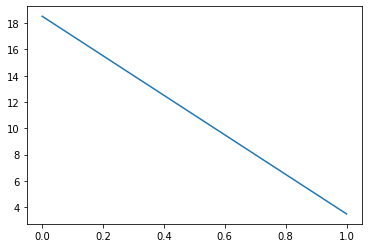

In [69]:
plt.plot(loss_list);

In [73]:
# フォワードプロパゲーション
# 1層目
w_in_1 = np.dot(X_train[0:10], w_1) + b_1
out_1 = sigmoid(w_in_1)

# 2層目
w_in_2 = np.dot(out_1, w_2) + b_2
out_2 = sigmoid(w_in_2)

# ３層目
w_in_3 = np.dot(out_2, w_3) + b_3
y_pred = softmax(w_in_3)
y_pred[0:5]

array([[2.65553657e-01, 1.70460083e-03, 2.01632813e-02, 4.82745083e-03,
        5.71951025e-02, 3.05834570e-01, 2.80821776e-01, 2.39790479e-03,
        5.19222820e-02, 9.57937455e-03],
       [8.74627935e-05, 3.36899656e-04, 4.15280164e-04, 1.80015224e-03,
        2.00721360e-01, 2.86458631e-02, 9.72241424e-05, 3.96996714e-02,
        7.73151271e-03, 7.20464574e-01],
       [1.70728717e-01, 2.18421262e-04, 2.67387960e-03, 7.73348675e-03,
        2.80510703e-02, 5.85660570e-01, 2.09403077e-02, 2.96375090e-04,
        1.71576775e-01, 1.21203976e-02],
       [6.66743083e-14, 3.42794683e-03, 1.36865090e-06, 1.08682755e-04,
        2.76210931e-07, 5.31100269e-06, 8.12669244e-11, 9.91003039e-01,
        3.16268447e-06, 5.45021259e-03],
       [1.08555194e-03, 8.74090149e-04, 1.31717620e-02, 1.07865793e-04,
        6.36587066e-03, 8.97112619e-03, 9.46711845e-01, 7.28244655e-05,
        2.22765786e-02, 3.62484796e-04]])

In [76]:
np.argmax(y_pred[0:5],axis=1)

array([5, 9, 5, 7, 6])

In [77]:
np.argmax(y_train[0:5], axis=1)

array([6, 9, 5, 7, 6])

## クラス化

In [84]:
class ScratchSimpleNeuralNetworkClassifier():
    def __init__(self, verbose=True, lr=0.1, sigma=0.01):
        self.verbose = True
        self.batch_size = 10 # バッチサイズ
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        self.sigma = 0.01 # ガウス分布の標準偏差
        self.lr = 0.1
        self.n_epoch = 5
        self.loss_list = []
        
        # それぞれの重み、バイアスの初期値
        self.w_1 = self.sigma * np.random.randn(self.n_features,self.n_nodes1)
        self.b_1 = self.sigma * np.random.randn(self.n_nodes1)
        self.w_2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.b_2 = self.sigma * np.random.randn(self.n_nodes2)
        self.w_3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.b_3 = self.sigma * np.random.randn(self.n_output)
    
    def fit(self, X_train, y_train): 
        get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=10)
        for epoch in range(self.n_epoch):
            print('epoch: {}'.format(epoch+1))
            for mini_X_train, mini_y_train in get_mini_batch:

                # forward
                # 1層目
                w_in_1 = np.dot(mini_X_train, self.w_1) + self.b_1
                out_1 = self._sigmoid(w_in_1) 

                # ２層目
                w_in_2 = np.dot(out_1, self.w_2) + self.b_2
                out_2 = self._sigmoid(w_in_2)

                # ３層目
                w_in_3 = np.dot(out_2, self.w_3) + self.b_3
                y_pred = self._softmax(w_in_3)
                

                # backpropagation
                # 3層目
                y_hat = y_pred - mini_y_train
                self.b_3 -= self.lr * np.mean(y_hat, axis=0)
                back_z2 = np.dot(y_hat, self.w_3.T)
                self.w_3 -= self.lr * np.dot(out_2.T, y_hat)/self.batch_size

                # 2層目
                back_a2 = back_z2 * (1 - self._sigmoid(w_in_2)) * self._sigmoid(w_in_2) #(10,200)
                self.b_2 -= self.lr * np.mean(back_a2, axis=0)
                back_z1 = np.dot(back_a2, self.w_2.T)
                self.w_2 -= self.lr * np.dot(out_1.T, back_a2)/self.batch_size


                # 1層目
                back_a1 = back_z1 * (1-self._sigmoid(w_in_1)) * self._sigmoid(w_in_1) #(10,400)(10,400)
                self.b_1 -= self.lr * np.mean(back_a1, axis=0)
                self.w_1 -= self.lr * np.dot(mini_X_train.T, back_a1)/self.batch_size
                
                
                
                
            # lossの格納
            self.loss_list.append(self._cross_entropy(y_pred, mini_y_train))
                
    def predict(self, X):
        
        # forward
        # 1層目
        w_in_1 = np.dot(X, self.w_1) + self.b_1
        out_1 = self._sigmoid(w_in_1) 
        # ２層目
        w_in_2 = np.dot(out_1, self.w_2) + self.b_2
        out_2 = self._sigmoid(w_in_2)
        # ３層目
        w_in_3 = np.dot(out_2, self.w_3) + self.b_3
        y_pred = self._softmax(w_in_3)
        return y_pred
    
    def _softmax(self, X):
        if X.ndim == 2:
            X = X.T
            X = X - np.max(X, axis=0)
            y = np.exp(X) / np.sum(np.exp(X), axis=0)
            return y.T

        X = X - np.max(X)
        return np.exp(X) / np.sum(np.exp(X))

    def _sigmoid(self, X):
        return 1/(1+np.exp(-X))
    
    def _cross_entropy(self,y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true*np.log(y_pred+delta))

In [85]:
# 学習
cls=ScratchSimpleNeuralNetworkClassifier()
cls.fit(X_train,y_train)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5


In [86]:
# 予測
cls.predict(X_train[0:10])

array([[1.92534887e-04, 8.66044571e-04, 6.53142234e-03, 1.28014813e-04,
        1.40699086e-03, 6.09202944e-03, 9.83990608e-01, 1.00532745e-04,
        6.24188256e-04, 6.76340675e-05],
       [2.25773781e-07, 2.06219014e-04, 2.42967389e-04, 7.05399735e-04,
        4.83932482e-01, 3.56908475e-03, 5.63700273e-05, 2.96201404e-02,
        3.84634822e-04, 4.81282476e-01],
       [3.20842339e-02, 3.88876562e-04, 3.87140565e-03, 1.66244107e-03,
        9.63338727e-03, 1.90075265e-01, 3.60315517e-02, 1.62010044e-04,
        7.07278255e-01, 1.88125736e-02],
       [2.15393814e-12, 1.08006214e-04, 2.27812329e-05, 1.44872225e-04,
        1.12283007e-08, 2.94622643e-07, 3.51578841e-11, 9.99395760e-01,
        8.99581014e-07, 3.27375190e-04],
       [3.86716827e-06, 1.54861791e-04, 9.41415659e-04, 2.61486887e-06,
        9.78430311e-05, 5.48242796e-04, 9.97989025e-01, 2.59503498e-06,
        2.57977747e-04, 1.55734627e-06],
       [9.26567492e-07, 1.54940546e-02, 3.01679700e-03, 3.41152488e-03,
   

In [81]:
np.argmax(cls.predict(X_train[0:10]), axis=1)

array([6, 4, 8, 7, 6, 8, 9, 8, 0, 1])

In [82]:
np.argmax(y_train[0:10], axis=1)

array([6, 9, 5, 7, 6, 8, 9, 8, 0, 1])

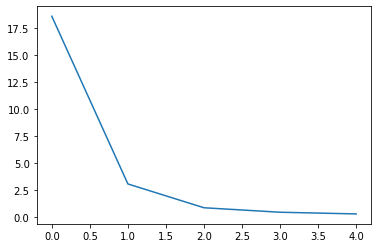

In [83]:
plt.plot(cls.loss_list);

In [88]:
cls.w_2

array([[-0.04752356, -0.01116454, -0.02432698, ...,  0.01590032,
        -0.02203637, -0.01942821],
       [-0.02641531,  0.0019915 , -0.01730184, ..., -0.04709532,
        -0.0158493 , -0.02150225],
       [ 0.01875989,  0.01550628,  0.0079539 , ..., -0.02583768,
         0.00933875, -0.03191508],
       ...,
       [ 0.03630938, -0.01820441,  0.02383364, ..., -0.00695979,
         0.01235886, -0.02458938],
       [-0.0211741 , -0.01617245, -0.00271825, ..., -0.01229068,
        -0.01621293, -0.01481077],
       [-0.00433718, -0.00238841, -0.02228155, ..., -0.03050808,
        -0.01504199, -0.0334816 ]])